# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [1]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [2]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [3]:
# import os
# if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
#     os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [22]:
!pip install gtts
!pip install wikipedia2vec==0.2.2
!pip install category-encoders
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

  Using cached https://files.pythonhosted.org/packages/a1/0c/4ca77eca3b739a4a08360930643f58d714e302fee0d2f8c654e67d9af8e7/gTTS-2.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e7/25/ca6e9cd3275bfc3097fe6b06cc31db6d3dfaf32e032e0f73fead9c9a03ce/gTTS-token-1.1.3.tar.gz
  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=b5eb2915bb99bb8a60ce5e09926db2f3e6885d9019340d32bad61d1df430c335
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token
     |████████████████████████████████| 1.1MB 3.5MB/s 
  Using cached https://files.pythonhosted.org/packages/20/95/d23071d0992dabcb61c948fb118a90683193befc88c23e745b050a29e7db/marisa-trie-0.7.5.tar.gz
  Using cached https://files.pythonhosted.org/packages/23/03/4fb04da533c7e237c0104151c028d8bff856293d34e51d208c529696fb79/mwparserfromhell-0.5.4.tar.gz
  Created wheel for wikipedia2vec: filename=wikipedia2v

In [24]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
        os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_nlp.txt') \
                     and os.path.exists(os.getcwd()+'/P6_functions.py')):
        print("ERROR: Make sure 'P6_functions.py' and \
'requirements_nlp.txt' are in the current working directory")

!pip install -r requirements_nlp.txt

In [25]:
from P6_functions import *

Installations (creating the requirements file)

In [26]:
# !pip freeze > requirements_nlp.txt

Importation of modules and packages. 

In [27]:
import io

import string

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Setting pandas display options.

In [28]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [29]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [30]:
speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of 9 distinct .csv files we'll load in a dictionnary of dataframes.

In [31]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [32]:
speak('Datasets successfully imported')

## 1 Data extraction

### 1.1 Categories

Unfolding categories using the 'product_category_tree' colum

In [50]:
# sample checking
df['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [51]:
# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [52]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [53]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
52c5fe837181962a7c1d5883bb9d7007,Beauty and Personal Care,Beauty and Personal Care/Fragrances,Beauty and Personal Care/Fragrances/Deodorants,Beauty and Personal Care/Fragrances/Deodorants/Combos,Beauty and Personal Care/Fragrances/Deodorants/Combos/Yardley Combos,Beauty and Personal Care/Fragrances/Deodorants/Combos/Yardley Combos/
260c74b5a09272dec1a8207db3541a0d,Baby Care,Baby Care/Baby Bath & Skin,Baby Care/Baby Bath & Skin/Baby Bath Towels,Baby Care/Baby Bath & Skin/Baby Bath Towels/BornBabyKids Baby Bath Towels,Baby Care/Baby Bath & Skin/Baby Bath Towels/BornBabyKids Baby Bath Towels/,Baby Care/Baby Bath & Skin/Baby Bath Towels/BornBabyKids Baby Bath Towels//
c9531b92270ef77516d5b5b7ba2568e9,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Maxima Wrist Watches,Watches/Wrist Watches/Maxima Wrist Watches/,Watches/Wrist Watches/Maxima Wrist Watches//,Watches/Wrist Watches/Maxima Wrist Watches///


Let's see how much items are in each category

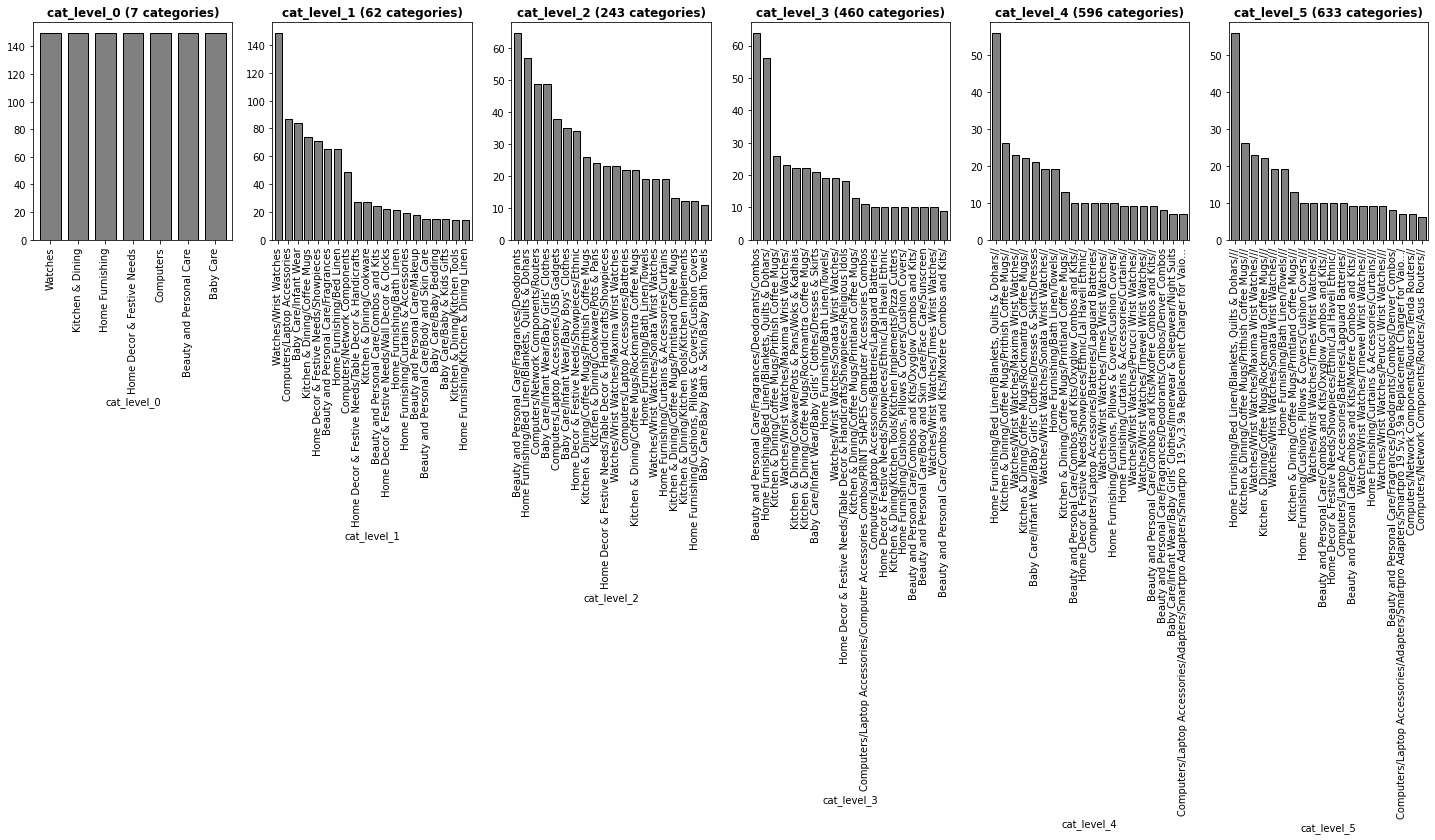

In [54]:
fig = plt.figure(figsize=(25,4))
for i, col in enumerate(df_cat_level.columns,1):
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:20].plot.bar(width=0.75, color='grey', ec='k', ax=ax)
    ax.set_title(col+f' ({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [55]:
df_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [56]:
df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                        'Baby Care': 'Baby', 
                                        'Watches': 'Watches',
                                        'Home Decor & Festive Needs': 'Decor',
                                        'Kitchen & Dining': 'Kitchen',
                                        'Beauty and Personal Care': 'Beauty',
                                        'Computers': 'Computers'})

### 1.2 Products descriptions

In [57]:
# extracting only useful data
df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

In [58]:
df_desc_cat.head()

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."


In [59]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc_cat['description'].values)
print("total nb of words in the whole corpus: ", len(corpus.split()))

total nb of words in the whole corpus:  80013


In [60]:
df_desc_cat

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n Price: Rs...
fd6cbcc22efb6b761bd564c28928483c,Baby,Wallmantra Large Vinyl Sticker Sticker,"Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n Price: Rs. 1,896\..."
5912e037d12774bb73a2048f35a00009,Baby,Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker,Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberly...


### 1.3 Global preprocessing

- removing the stopwords

In [61]:
# Stopwords
english_sw = nltk.corpus.stopwords.words('english')
single_let_sw = list(string.ascii_lowercase)
sw = list(set(english_sw + single_let_sw))
len(sw)

197

In [62]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

In [63]:
# # to keep only names and adjectives
# lambda x: [word for word,tag in nltk.pos_tag(x) if ('NN' or 'JJ') in tag])

In [64]:
# Apply the transformations to descriptions and to product names

df_desc_cat['desc_clean'] = \
    df_desc_cat['description'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                               .apply(lambda x: ' '.join(x))

df_desc_cat['pname_clean'] = \
    df_desc_cat['product_name'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                              .apply(lambda x: ' '.join(x))

In [65]:
df_desc_cat.head(3)

,category,product_name,description,desc_clean,pname_clean
uniq_id,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",key elegance polyester multicolor abstract eyelet door floral curtain elegance polyester multico...,elegance polyester multicolor abstract eyelet door curtain
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",sathiyas cotton bath towel bath towel yellow blue bath towel machine washable material cotton de...,sathiyas cotton bath towel
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",key eurospa cotton terry face towel size small height inch gsm eurospa cotton terry face towel p...,eurospa cotton terry face towel set


## 4 GridSearch optimization

In [1]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.stem.snowball import EnglishStemmer
import spacy

In [81]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

### 4.1 Optimize preprocessing (document-terms matrix) -> KMeans clustering

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix) with various options (binary, max_features, etc.)
- Dimensionality reduction (PCA, TruncatedSVD, ...)
- KMeans clustering (7 categories)

Trying to found the BOW encoding that gives the best KMeans score.

In [447]:
# Define the stemmer or the lemmatizer
stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0],#,0.05,0.1],
              'custtrans__max_df': [0.5,0.6,0.7,0.8,0.9,1.0],
              'custtrans__max_features': [400,450,500,550,600],
              'custtrans__ngram_range': [(1,1), (1,2), (1,3)],
              'custtrans__binary': [False, True],
              'custtrans__tfidf_on': [True, False],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.5, 0.55, 0.6, 0.65, 0.7],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [448]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

1/1800:
2/1800:
3/1800:
4/1800:
5/1800:
6/1800:
7/1800:
8/1800:
9/1800:
10/1800:
11/1800:
12/1800:
13/1800:
14/1800:
15/1800:
16/1800:
17/1800:
18/1800:
19/1800:
20/1800:
21/1800:
22/1800:
23/1800:
24/1800:
25/1800:
26/1800:
27/1800:
28/1800:
29/1800:
30/1800:
31/1800:
32/1800:
33/1800:
34/1800:
35/1800:
36/1800:
37/1800:
38/1800:
39/1800:
40/1800:
41/1800:
42/1800:
43/1800:
44/1800:
45/1800:
46/1800:
47/1800:
48/1800:
49/1800:
50/1800:
51/1800:
52/1800:
53/1800:
54/1800:
55/1800:
56/1800:
57/1800:
58/1800:
59/1800:
60/1800:
61/1800:
62/1800:
63/1800:
64/1800:
65/1800:
66/1800:
67/1800:
68/1800:
69/1800:
70/1800:
71/1800:
72/1800:
73/1800:
74/1800:
75/1800:
76/1800:
77/1800:
78/1800:
79/1800:
80/1800:
81/1800:
82/1800:
83/1800:
84/1800:
85/1800:
86/1800:
87/1800:
88/1800:
89/1800:
90/1800:
91/1800:
92/1800:
93/1800:
94/1800:
95/1800:
96/1800:
97/1800:
98/1800:
99/1800:
100/1800:
101/1800:
102/1800:
103/1800:
104/1800:
105/1800:
106/1800:
107/1800:
108/1800:
109/1800:
110/1800:
111/1800

In [418]:
# gsc.transform(df_desc_cat[['desc_clean', 'pname_clean']]).shape

(1050, 1000)

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('gsc_XXX.pkl', 'wb') as file:
#     pickle.dump(gsc_pname, file)

In [ ]:
# ### Loading the results
# import dill as pickle
# with open('gsc_XXX.pkl', 'rb') as file:
#     gsc_pname = pickle.load(file)

In [449]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_

scores_pname_df = pd.DataFrame(gsc_res['scores'],
                         index = pd.DataFrame(gsc_res['params']).iloc[:,0])
# scores_pname_df

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.5, 'custtrans__max_features': 500, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.6, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None}
Best refit score: 0.4019957322565853


ARI 0.35 0.34 0.32

Storing the results of the best model

In [ ]:
# df_desc_cat[['desc_clean', 'pname_clean']]

In [ ]:
df_res_clust['preproc_km'] = \
  gsc.best_estimator_.predict(df_desc_cat[['desc_clean', 'pname_clean']])

In [ ]:
# small_pipe = Pipeline(gsc.best_estimator_.steps[0:-1])
# before_clust = small_pipe.transform(df_desc_cat[['desc_clean', 'pname_clean']])
# before_clust.shape

Plotting the results of the clustering optimization

In [450]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'custtrans__pname_weight',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.09,40.86,2.74,0.48,0.27,0.44,0.54,0.48
0.55,0.10,46.24,2.97,0.51,0.31,0.49,0.55,0.52
0.60,0.11,46.61,3.12,0.57,0.40,0.55,0.59,0.57
0.65,0.11,45.85,2.24,0.54,0.24,0.47,0.67,0.55
0.70,0.07,42.93,2.27,0.53,0.22,0.45,0.66,0.53


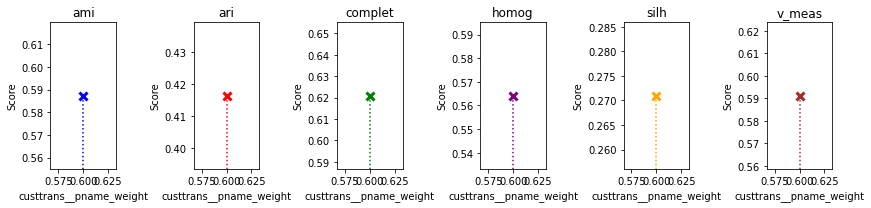

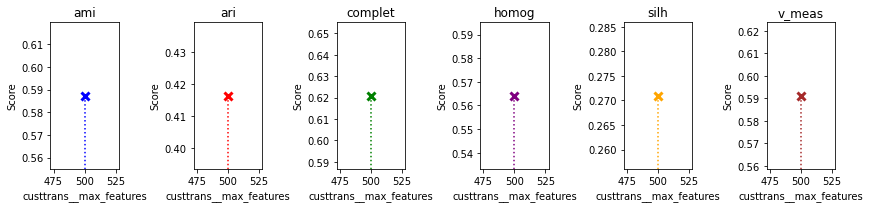

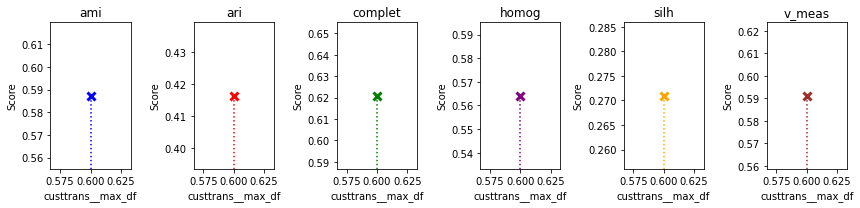

In [465]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_df', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

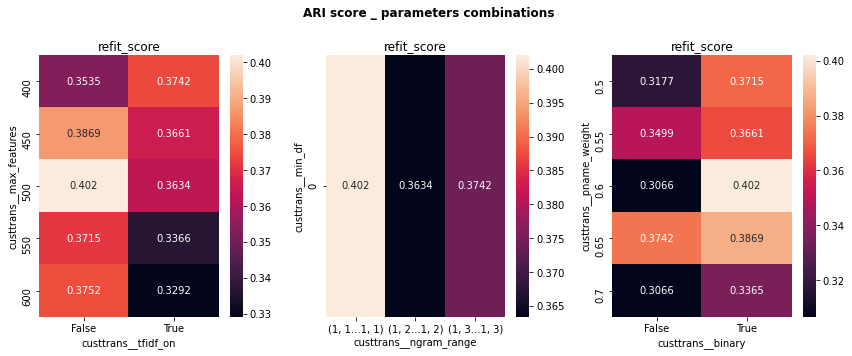

In [453]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'custtrans__ngram_range']
params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

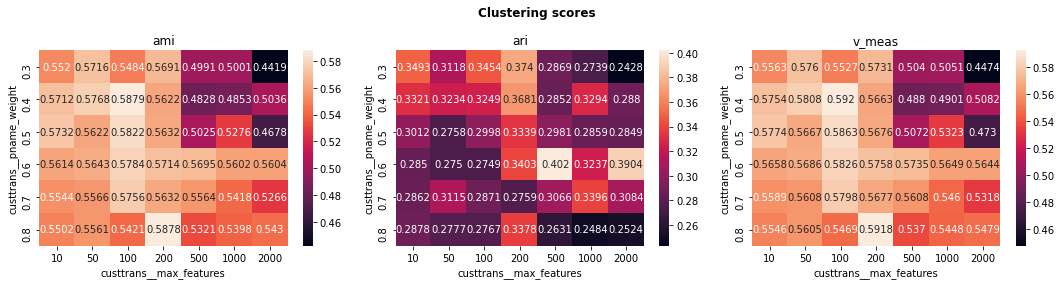

In [437]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(15,4))
params = ['custtrans__pname_weight', 'custtrans__max_features']

scores = ['ami', 'ari', 'v_meas'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params,
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

### 4.2 Optimize preprocessing (dimension reduction) -> KMeans clustering

In [483]:

# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('dimreduc', PCA()),
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0],
              'custtrans__max_df': [0.5],
              'custtrans__max_features': [500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True],
              'custtrans__tfidf_on': [False],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.6],
              'dimreduc': [PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14),
                           ], #[TSNE_wrapper(random_state=14), UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,7,10,15,20,50,100],# [2,3],
            #   'svd__n_iter': [4,5,6],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [485]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_

scores_pname_df = pd.DataFrame(gsc_res['scores'],
                               index = pd.DataFrame(gsc_res['params']).iloc[:,0])
# scores_pname_df

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.5, 'custtrans__max_features': 500, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.6, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': PCA(copy=True, iterated_power='auto', n_components=100, random_state=14,
    svd_solver='auto', tol=0.0, whiten=False), 'dimreduc__n_components': 10}
Best refit score: 0.4147948996897538


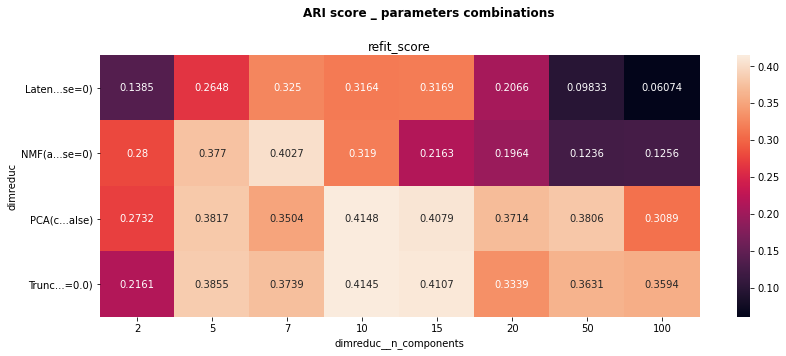

In [486]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc', 'dimreduc__n_components']
# params2 = ['custtrans__min_df', 'custtrans__ngram_range']
# params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,1,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

# ax2 = fig.add_subplot(1,3,2)
# plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

# ax3 = fig.add_subplot(1,3,3)
# plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

### 4.3 Optimize preprocessing and choice of topics modelers

In [546]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0], # [0,0.01, 0.02]
              'custtrans__max_df': [0.5], #[0.1,0.15,0.2,0.3]
              'custtrans__max_features': [125,126,127,128,129], # [100,125,150,175,200,250,300,400,500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True], # False
              'custtrans__tfidf_on': [True], # False
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.92,0.93,0.94,0.95], # [0.65,0.7,0.75,0.8,0.85,0.9,0.9],
              'clusterer__n_model': ['nmf'], # ['nmf', 'lda', 'lsa']
              'clusterer__n_components': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [549]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_

scores_pname_df = pd.DataFrame(gsc_res['scores'],
                               index = pd.DataFrame(gsc_res['params']).iloc[:,0])

# -----Product name
# Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'nmf',
# 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None,
# 'custtrans__max_df': 0.5, 'custtrans__max_features': 127, 'custtrans__min_df': 0,
# 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.94, 'custtrans__stemmer': None,
# 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
# Best refit score: 0.5536655788135667

-----Product name
Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'nmf', 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.5, 'custtrans__max_features': 127, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.94, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
Best refit score: 0.5536655788135667


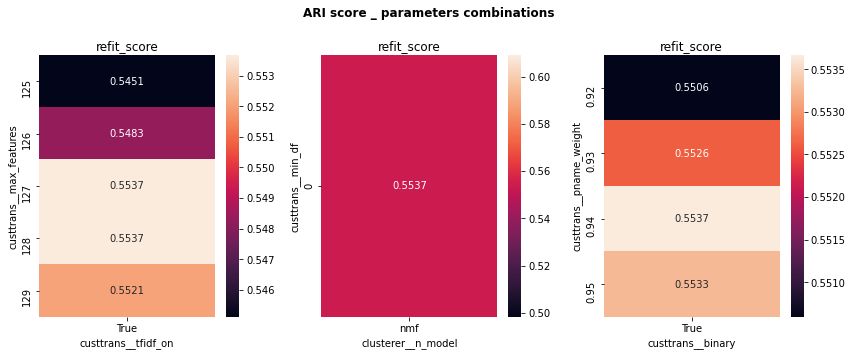

In [550]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'clusterer__n_model']
params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

In [ ]:
# speak("youpi cé fini")

### 4.4 Optimize preprocessing (pretrained word embeddings)

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Clustering using topics modeling (7 topics)

In [ ]:
sklearn.discriminant_analysis.LinearDiscriminantAnalysis(*, solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001

#### Wiki2vec

In [551]:
## Using a pretrained model
# https://wikipedia2vec.github.io/wikipedia2vec/pretrained/
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load("../DATA/enwiki_20180420_100d.pkl") # 100 dimensions

In [7]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer()),# Custom NLP preprocessor
                 ('dimreduc', PCA(random_state=14)),
                 ('clusterer', KMeans(random_state=14)),#TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__stopwords': [None],
              'custtrans__stemmer': [None],
              'custtrans__lemmatizer': [None],
              'custtrans__keep_tags': [None],
              'custtrans__min_df': [0],
              'custtrans__max_df': [0.1,0.2,0.5],
              'custtrans__max_features': [30,50, 70,100,200,500], # [100,125,150,175,200,250,300,400,500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [wiki2vec],
              'custtrans__pname_weight': [0.5,0.6,0.7,0.8,0.95], # [0.65,0.7,0.75,0.8,0.85,0.9,0.9],
              'dimreduc': [PCA(random_state=14), 
                        #    LDA(random_state=14),
                        #    NMF(random_state=14),
                           LinearDiscriminantAnalysis(random_state=14),
                           TruncatedSVD(random_state=14),
                           ], #[TSNE_wrapper(random_state=14), UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,10,20,50,100],# [2,3],
            #   'clusterer__n_model': ['nmf', 'lda', 'lsa'],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

NameError: ignored

In [8]:
##### Perform the grid search
gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

NameError: ignored

In [562]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_

scores_pname_df = pd.DataFrame(gsc_res['scores'],
                               index = pd.DataFrame(gsc_res['params']).iloc[:,0])

# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.2, 'custtrans__max_features': 70, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': <wikipedia2vec.wikipedia2vec.Wikipedia2Vec object at 0x7fa00743fd18>}
# Best refit score: 0.42056239767415315

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 0.2, 'custtrans__max_features': 70, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': True, 'custtrans__w2v': <wikipedia2vec.wikipedia2vec.Wikipedia2Vec object at 0x7fa00743fd18>}
Best refit score: 0.42056239767415315


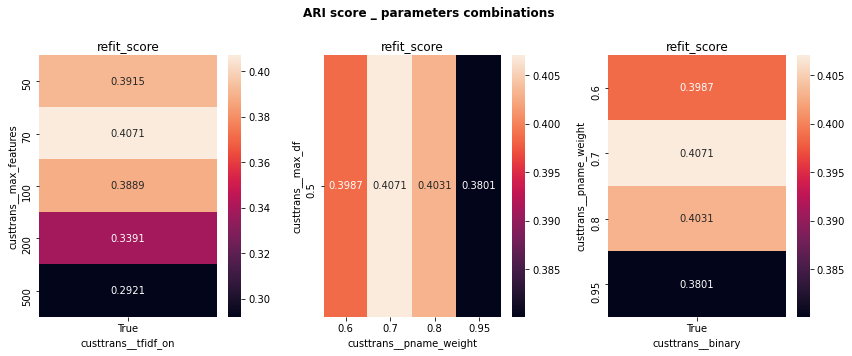

In [558]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__max_df', 'custtrans__pname_weight']
params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

#### Universal Sentence Encoder (USE)

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow==2.1.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# récuperer l'encodeur depuis le site de google
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
# encoding each product_name
tf_tensor = encoder(df_desc_cat['product_name'].values)
# put in a dataframe
desc_emb = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)),
                        index=df_desc_cat['product_name'].index,
                        columns=['dim_'+str(i) for i in range(512)])

## 5 Comparison of clusters labels with true categories

#### Comparison between scores...

In [ ]:
# # Comparison of clusters labels with true categories

# from sklearn.metrics import adjusted_rand_score

# ser_ari_pairs_models = comp_clust_metrics_col_pairs(df_res_clust,
#                                                     first_vs_others=True,
#                                                     print_opt=False,
#                                                     n_score='ari')

# # Plotting the results

# fig = plt.figure(figsize=(3,3))
# ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
# plt.ylabel('ARI score')
# # plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# # plt.gca().set(ylim=(0.85,1))
# plt.show()

#### ARI scores (true categories vs. clusters)

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
df_res_clust.columns

In [ ]:
adjusted_rand_score(df_res_clust['categories'],
                    df_res_clust['w2v_km_WD'])

In [ ]:
ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

In [ ]:
fig = plt.figure(figsize=(2,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Confusion matrix

In [ ]:
cat_clust_confmat = confusion_matrix_clust(df_res_clust['categories'],
                                           df_res_clust['w2v_km_WD'],
                                           normalize=False,
                                           margins_sums=True,
                                           margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

In [ ]:
cm = confusion_matrix_clust(df_res_clust['categories'],
                            df_res_clust['w2v_km_WD'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

####  Sankey confusion diagram

In [ ]:
# # to get interactive graph
# plot_sankey_confusion_mat(cm, static=False, font_size=14)

# to get static graph static
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 1)
Image(img_bytes)

#### 2D visualisation

In [ ]:
df_proj = pd.DataFrame(before_clust,
                       index=df_res_clust.index)
df_proj.shape

In [ ]:
# Plotting a projection of the points (true categories vs. clusters) (PCA 0.71, UMAP 0.81, t-SNE 0.83)
ind_samp = df_res_clust.sample(200).index
plot_projection_cat_clust(df_proj.loc[ind_samp], model=None,
                 ser_clust=df_res_clust['w2v_km_WD'].loc[ind_samp], # clustering already done
                 true_cat=df_res_clust['categories'].loc[ind_samp], # true categories
                 proj='t-SNE', size=35, edgelinesize=3, legend_on=True,
                 title="True categories vs. Clusters ( BOW -> t-SNE )",
                 figsize=(8, 5), palette='tab10',
                 fig=None, ax=None, random_state=14, bboxtoanchor=(1,1))

- calcul de la pertinence des catégories trouvées par rapport aux catégories initiales et représentation graphique

- optimisation du nombre de catégories par mesure de la cohérence des mots les plus représentatifs de chaque catégorie (nécessite d'entraîner un modèle word2vec)
- représentation des catégories (des mots les plus représentatifs qui les composent) avec t-SNE
- essai direct de clustering sur la représentation des mots par Word2Vec

- Latent Dirichlet Allocation pour trouver d'autres clusters

- comment mettre en place un vote permettant d'aggréger le résultat de plusieurs clusterings différents lorsque les catégories n'ont pas les mêmes numéros ? 